In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Parameters for data
n = 30
m = 0  # Mean of data-generating distribution
s = 1  # Standard deviation of data-generating distribution
x = norm(loc=m, scale=s).rvs(size=n)  # Generate data

# Prior hyperparameters
theta_0 = 1.0  # Mean of prior for theta
tau_0 = 2.0    # Std dev of prior for theta
alpha = 2.0    # Shape parameter for Gamma prior on tau
lambd = 1.0    # Rate parameter for Gamma prior on tau

# Gibbs sampler settings
C = 2       # Number of chains
G = 100     # Number of samples
theta = np.zeros((C, G))  # Storage for theta samples
tau = np.zeros((C, G))    # Storage for tau samples


In [2]:
# Initialization
theta[:, 0] = theta_0
tau[:, 0] = lambd

for c in range(C):  # Loop over chains
    for g in range(1, G):
        # Sample theta | tau, x directly from the Normal distribution
        tau_post = tau[c, g-1]
        mean_theta = (n * np.mean(x) * tau_post + theta_0 / tau_0**2) / (n * tau_post + 1 / tau_0**2)
        var_theta = 1 / (n * tau_post + 1 / tau_0**2)
        theta[c, g] = norm(loc=mean_theta, scale=np.sqrt(var_theta)).rvs()

        # Metropolis step for tau | theta, x
        tau_current = tau[c, g-1]
        tau_proposal = gamma(a=alpha, scale=1/lambd).rvs()  # Proposal distribution (Gamma)
        
        # Calculate the log of the joint posterior
        log_posterior_proposal = (
            -0.5 * tau_proposal * np.sum((x - theta[c, g])**2)
            + (alpha - 1) * np.log(tau_proposal) - lambd * tau_proposal
        )
        log_posterior_current = (
            -0.5 * tau_current * np.sum((x - theta[c, g])**2)
            + (alpha - 1) * np.log(tau_current) - lambd * tau_current
        )

        # Calculate acceptance ratio
        acceptance_ratio = np.exp(log_posterior_proposal - log_posterior_current)

        # Accept or reject the proposal
        if np.random.uniform(0, 1) < acceptance_ratio:
            tau[c, g] = tau_proposal
        else:
            tau[c, g] = tau_current

# Burn-in period
burn = 20


In [6]:
# Calculate credible intervals for theta and tau
theta_samples = theta[:, burn:].flatten()
tau_samples = tau[:, burn:].flatten()
credible_level = 0.95

# Credible interval for theta
theta_lower = np.percentile(theta_samples, (1 - credible_level) / 2 * 100)
theta_upper = np.percentile(theta_samples, (1 + credible_level) / 2 * 100)

# Credible interval for tau
tau_lower = np.percentile(tau_samples, (1 - credible_level) / 2 * 100)
tau_upper = np.percentile(tau_samples, (1 + credible_level) / 2 * 100)

print(tau_lower, ",", tau_upper)


0.08615791602607412 , 0.4494940931196453


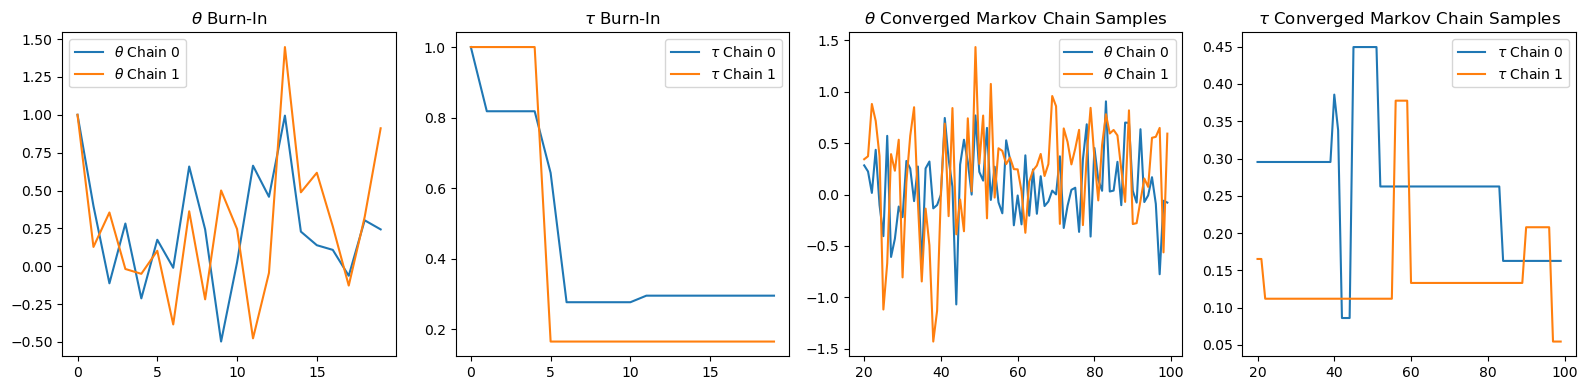

In [7]:
# Visualization
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain Samples")

for c in range(C):
    # Burn-in period
    ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c}")
    ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c}")
    
    # Stationary samples
    ax[2].plot(np.arange(burn, G), theta[c, burn:], label=f"$\\theta$ Chain {c}")
    ax[3].plot(np.arange(burn, G), tau[c, burn:], label=f"$\\tau$ Chain {c}")

for a in ax:
    a.legend()

plt.tight_layout()
plt.show()